# Looking into the 3 CAVIAR outliers

Here we want to understand the examples that CAVIAR `-c 1` and susie `L 1` do not agree for `n = 1` causal variable.

The plan is to pin-point the data in question and get the corresponding data-set, then use interactive analysis to explore in detail.

In [1]:
%revisions -s

Revision,Author,Date,Message
8f4f078,Gao Wang,2018-06-03,Add z-score check
880f1d3,Gao Wang,2018-06-03,Add z-score check
6b6455a,Gao Wang,2018-06-01,Add another gene's example for susie single effect model
074f4db,Gao Wang,2018-06-01,Add susie L=5 comparison
e4990ea,Gao Wang,2018-06-01,Add a comment on -c 1 case for CAVIAR
ecefc0f,Gao Wang,2018-06-01,Update CAVIAR table
9894dcf,Gao Wang,2018-06-01,Update documentation
e6fce6f,Gao Wang,2018-06-01,Finish up one CAVIAR example
7705774,Gao Wang,2018-06-01,Add interactive notebook for CAVIAR issues


## Extract simulated dataset

In [1]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

In [ ]:
dataset = c('~/Documents/GTExV8/Toys/Thyroid.ENSG00000144445.RDS', '~/Documents/GTExV8/Toys/Thyroid.ENSG00000155324.RDS', '~/Documents/GTExV8/Toys/Thyroid.ENSG00000156738.RDS')
out = dscrutils::dscquery('susie_comparison', 
                          targets = "liter_data.dataset lm_less.n_signal lm_less", 
                          conditions = "lm_less.n_signal = 1")

In [9]:
out[which(out$liter_data.dataset %in% dataset),]

,DSC,liter_data.dataset,lm_less.n_signal,lm_less.output.file
39,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000144445.RDS,1,lm_less/liter_data_39_summarize_ld_1_lm_less_1
48,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000155324.RDS,1,lm_less/liter_data_48_summarize_ld_1_lm_less_1
49,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000156738.RDS,1,lm_less/liter_data_49_summarize_ld_1_lm_less_1


In [11]:
bash:
    cp susie_comparison/lm_less/liter_data_{39,48,49}_summarize_ld_1_lm_less_1.pkl ../data

## The `ENSG00000156738` example

Here I take one data-set and use narratives to work all the way to the point we get CAVIAR and susie results. Hopefully this transparent process will help us pin-pointing the problem.

Load data first:

In [2]:
name = 'ENSG00000156738'
prefix = paste0("/tmp/", name, '_CAVIAR')

In [3]:
dat = dscrutils:::read_dsc('../data/liter_data_49_summarize_ld_1_lm_less_1.pkl')$data

### Data preparation

In [4]:
names(dat)

[1] "X"                 "y"                 "Z"                
 [4] "chrom"             "pos"               "true_coef"        
 [7] "residual_variance" "Y"                 "allele_freq"      
[10] "V"

In [5]:
dim(dat$X)

[1]  574 1001

The data has two response variables. We will focus on `Y[,1]`:

In [6]:
dim(dat$Y)

[1] 574   2

The true signal is `816`.

In [7]:
which(dat$true_coef[,1] != 0)

[1] 816

Now output LD and summary stats for CAVIAR

In [8]:
r2 = cor(dat$X)
r2 = r2 ^ 2 * sign(r2)
write.table(r2,paste0(prefix, '.ld'),quote=F,col.names=F,row.names=F)

In [9]:
source('modules/regression.R')
source('modules/fit_caviar.R')
res = mm_regression(as.matrix(dat$X), as.matrix(dat$Y))
z_score = res[1,,]/res[2,,]
cfg = write_caviar_sumstats(z_score, prefix)

### show the top z-scores as is

In [22]:
max10 = head(order(abs(z_score[,1]), decreasing = T),10)
max10

[1] 816 769 770 771 791 796 797 798 814 776

In [21]:
z_score[max10]

[1] -176.5660 -163.0048 -163.0048 -163.0048 -163.0048 -163.0048 -163.0048
 [8] -163.0048 -163.0048 -159.4046

### CAVIAR

Now run CAVIAR, with prior 0.001 for 1 effect in 1000.

In [12]:
cmd = paste("CAVIAR", "-z", cfg$z, "-l", paste0(prefix, ".ld"), "-o", prefix, "-r 0.001")
dscrutils:::run_cmd(cmd)

[1] 0

In [39]:
log <- readLines(cfg$log)
library(dplyr)
library(magrittr)
# read output tables
snp <- read.delim(cfg$post)  
stopifnot(ncol(snp) == 3)
names(snp) <- c("snp", "snp_prob_set", "snp_prob")
snp$snp <- as.character(snp$snp)
snp <- rank_snp(snp)

# `set` of snps
set <- readLines(cfg$set)
set_ordered <- left_join(data_frame(snp = set), snp, by = "snp") %>% 
arrange(rank) %$% snp

In [40]:
set_ordered

[1] "816"

In [42]:
head(snp, 15)

rank,snp,snp_prob,snp_prob_cumsum,snp_prob_set
1,816,1.00000e+00,0.5000,5.00000e-01
2,769,1.25000e-01,0.5625,6.25000e-02
3,770,1.25000e-01,0.6250,6.25000e-02
4,771,1.25000e-01,0.6875,6.25000e-02
5,791,1.25000e-01,0.7500,6.25000e-02
6,796,1.25000e-01,0.8125,6.25000e-02
7,797,1.25000e-01,0.8750,6.25000e-02
8,798,1.25000e-01,0.9375,6.25000e-02
9,814,1.25000e-01,1.0000,6.25000e-02
10,954,8.85469e-42,1.0000,4.42735e-42


So here CAVIAR reports one set that contains one causal variant `816`. Notice:

- The ordering is largely consistent with ordering of z-scores.
- In the CAVIAR call I did not explicitly specify `-c 1` but I still get this one signal reported in their `*_set` file. When I do specify `-c 1`, **I will get `snp_prob_set` of 1 for 816 and 0 for others** (result not shown). The default is `-c 2`.
- also in CAVIAR although `816` reports `snp_prob` 1.0, when `-c` is not set, the `snp_prob_set` it reports is 0.5 as shown in the table. The other high LD SNPs do share the rest 0.5.

Also note that in CAVIAR original output file they use `Causal_Post._Prob.` for `snp_prob`, interpreted as "the probability of each variant is causal", and `Prob_in_pCausalSet` for `snp_prob_set`, interpreted as "the amount that this variant contributes to credible set". See documentation [here](https://github.com/fhormoz/caviar/issues/1).

### susie single effect

Set `L=1` for the susie fit, which is just a single effect regression. In sum:

- Susie still picks `816` the top one, as expected, but the PIP is 0.16
- There are 14 other variables have PIP under 0.08

In [17]:
# Here my X and Y are already centered

X = scale(dat$X,center=FALSE, scale=TRUE)
Y = dat$Y[,1]
fit = susieR:::single_effect_regression(Y,X,sa2=0.2,s2=var(dat$Y[,1]))

In [18]:
which.max(fit$alpha)

[1] 816

For L=1 the `alpha` is the PIP:

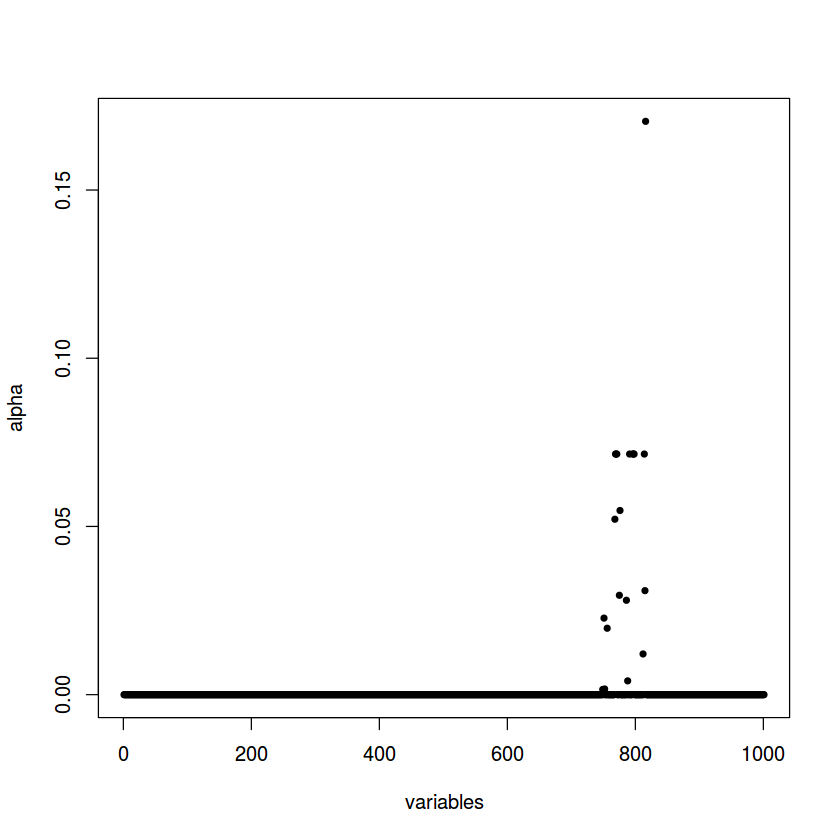

In [21]:
plot(fit$alpha, pch=20, xlab='variables', ylab = 'alpha')

Notice that ordering of SNPs are largely consistent between CAVIAR and susie.

In [44]:
order(fit$alpha, decreasing=T)[1:15]

[1] 816 769 770 771 791 796 797 798 814 776 768 815 775 786 751

Purity of susie CS, defined by the min of abs(LD):

In [28]:
cs = which(susieR:::in_CS_x(fit$alpha)>0)
purity = r2[cs,cs]
purity

1.0000000,0.9963420,0.9969772,0.9969772,0.9969772,0.9939427,0.9963460,0.9939427,0.9969772,0.9969772,0.9969772,0.9969772,0.9969772,0.9939341,0.9933067
0.9963420,1.0000000,0.9993619,0.9993619,0.9993619,0.9963506,0.9987251,0.9963506,0.9993619,0.9993619,0.9993619,0.9993619,0.9993619,0.9963420,0.9957090
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9939427,0.9963506,0.9969858,0.9969858,0.9969858,1.0000000,0.9963545,0.9939513,0.9969858,0.9969858,0.9969858,0.9969858,0.9969858,0.9939427,0.9933153
0.9963460,0.9987251,0.9993658,0.9993658,0.9993658,0.9963545,1.0000000,0.9963545,0.9993658,0.9993658,0.9993658,0.9993658,0.9993658,0.9963460,0.9957130
0.9939427,0.9963506,0.9969858,0.9969858,0.9969858,0.9939513,0.9963545,1.0000000,0.9969858,0.9969858,0.9969858,0.9969858,0.9969858,0.9939427,0.9933153
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467


In [29]:
length(cs)

[1] 15

In [31]:
min(abs(purity))

[1] 0.9933067

### single effect BF's

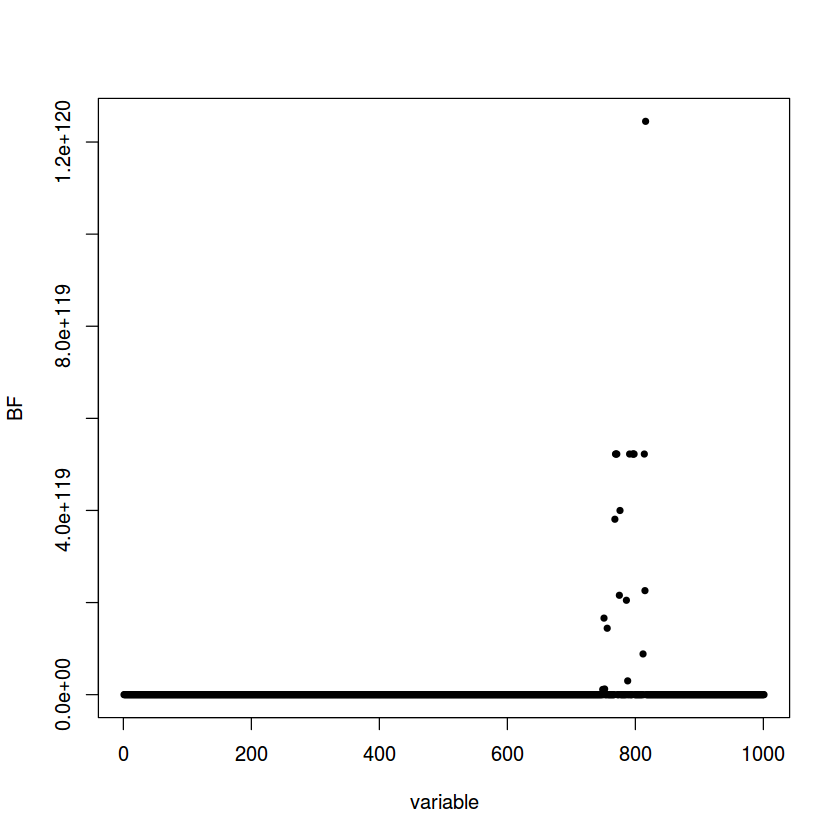

In [35]:
plot(exp(fit$lbf), pch = 20, ylab = 'BF', xlab = 'variable')

### susie L=5

To fairly compare with not setting CAVIAR `-c` option here I set susie `L = 5` and fit a susie run:

In [5]:
fit = susieR::susie(dat$X,dat$Y[,1],
                               L=5,
                               estimate_residual_variance = F, 
                               prior_variance=0.2, 
                               intercept=FALSE,
                               tol=1e-3)

In [6]:
susieR:::susie_get_niter(fit)

[1] 4

In [14]:
pip = 1 - apply(1 - fit$alpha, 2, prod)

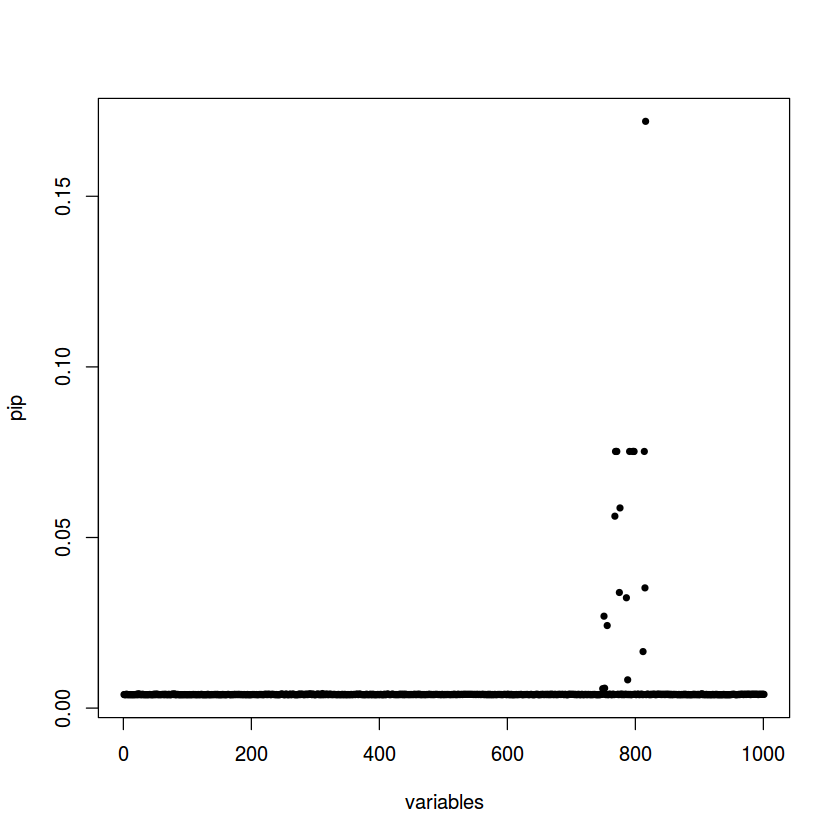

In [15]:
plot(pip, pch=20, xlab='variables', ylab = 'pip')

The PIP I get here are mostly identical to the single effect model `alpha`.

## The `ENSG00000155324` example

In [25]:
name = 'ENSG00000155324'
dat = dscrutils:::read_dsc('../data/liter_data_48_summarize_ld_1_lm_less_1.pkl')$data
r2 = cor(dat$X)
r2 = r2 ^ 2 * sign(r2)

In this example, I want to see the status of susie BF when the CS idenfied has minimum LD 0.96, as previously reported. Under the L=5 model it reported 6 SNPs.

In [28]:
X = scale(dat$X,center=FALSE, scale=TRUE)
Y = dat$Y[,1]
fit = susieR:::single_effect_regression(Y,X,sa2=0.2,s2=var(dat$Y[,1]))

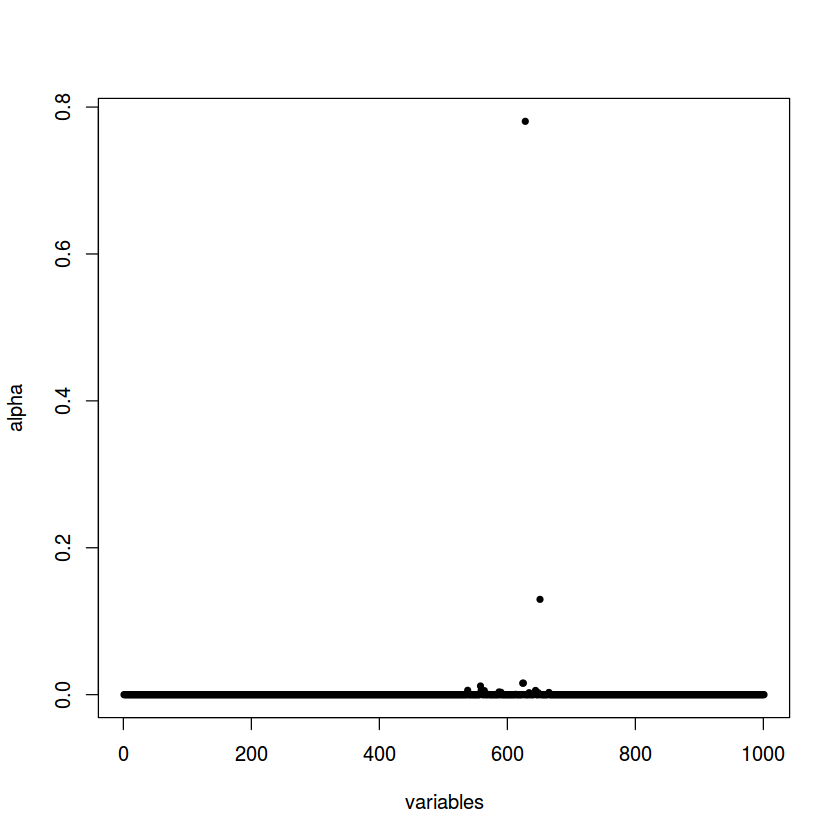

In [29]:
plot(fit$alpha, pch=20, xlab='variables', ylab = 'alpha')

In [30]:
cs = which(susieR:::in_CS_x(fit$alpha)>0)
purity = r2[cs,cs]
purity

1.0000000,0.9795675,0.9699838,0.9719937,0.9678303
0.9795675,1.0000000,0.9872564,0.9849938,0.9882706
0.9699838,0.9872564,1.0000000,0.9872842,0.9755299
0.9719937,0.9849938,0.9872842,1.0000000,0.9805825
0.9678303,0.9882706,0.9755299,0.9805825,1.0000000


In [32]:
min(abs(purity))

[1] 0.9678303

In [35]:
max(abs(purity-diag(nrow(purity))))

[1] 0.9882706

So under `L = 1` model the CS size is 5. The largest LD is 0.988, which splits away <0.2 of the PIP. The BF's are:

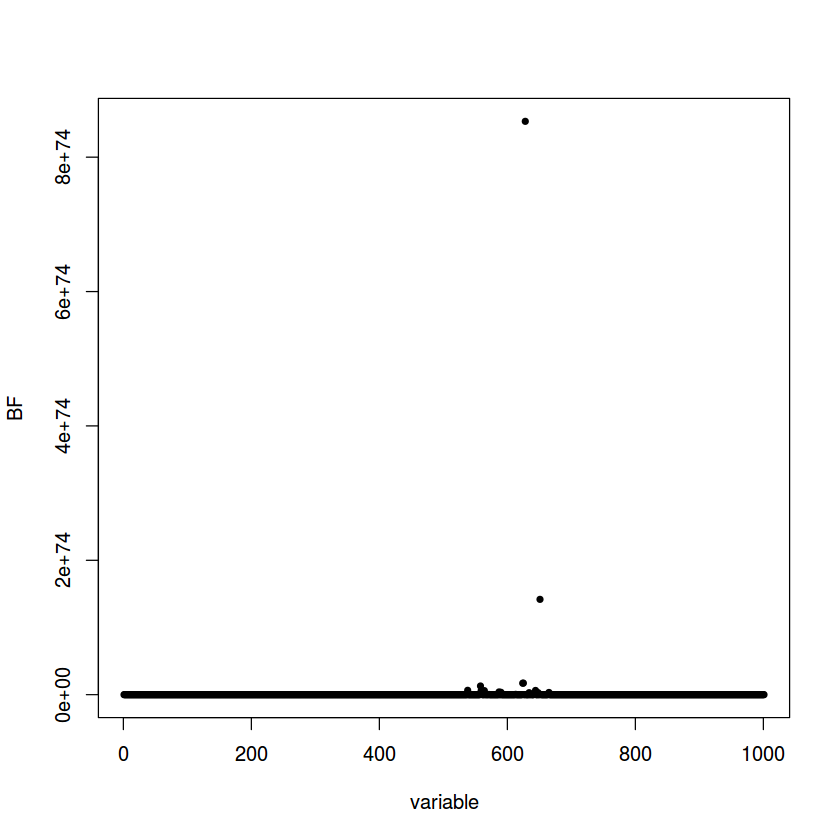

In [36]:
plot(exp(fit$lbf), pch = 20, ylab = 'BF', xlab = 'variable')